(bart_categorical)=
# Categorical regression

:::{post} May, 2024
:tags: BART, regression
:category: beginner, reference
:author: Pablo Garay, Osvaldo Martin
:::

In this example, we will model outcomes with more than two categories.  
:::{include} ../extra_installs.md
:::

In [1]:
import os
import warnings

import arviz.preview as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import seaborn as sns

from scipy.special import softmax

warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
# set formats
RANDOM_SEED = 8457
az.style.use("arviz-variat")

## Hawks dataset  

Here we will use a dataset that contains information about 3 species of hawks (*CH*=Cooper's, *RT*=Red-tailed, *SS*=Sharp-Shinned). This dataset has information for 908 individuals in total, each one containing 16 variables, in addition to the species. To simplify the example, we will use the following 5 covariables:  
- *Wing*: Length (in mm) of primary wing feather from tip to wrist it attaches to.  
- *Weight*: Body weight (in gr).  
- *Culmen*: Length (in mm) of the upper bill from the tip to where it bumps into the fleshy part of the bird.  
- *Hallux*: Length (in mm) of the killing talon.  
- *Tail*: Measurement (in mm) related to the length of the tail.  

Also we are going to eliminate the NaNs in the dataset. With these we will predict the "Species" of hawks, in other words, these are our dependent variables, the classes we want to predict.  

In [3]:
# Load data and eliminate NANs
try:
    Hawks = pd.read_csv(os.path.join("..", "data", "Hawks.csv"))[
        ["Wing", "Weight", "Culmen", "Hallux", "Tail", "Species"]
    ].dropna()
except FileNotFoundError:
    Hawks = pd.read_csv(pm.get_data("Hawks.csv"))[
        ["Wing", "Weight", "Culmen", "Hallux", "Tail", "Species"]
    ].dropna()

Hawks.head()

Wing  Weight  Culmen  Hallux  Tail Species
0  385.0   920.0    25.7    30.1   219      RT
2  381.0   990.0    26.7    31.3   235      RT
3  265.0   470.0    18.7    23.5   220      CH
4  205.0   170.0    12.5    14.3   157      SS
5  412.0  1090.0    28.5    32.2   230      RT

## EDA  
The following compares covariables to get a rapid data visualization for the 3 species.  

/home/osvaldo/anaconda3/envs/pymc/lib/python3.13/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


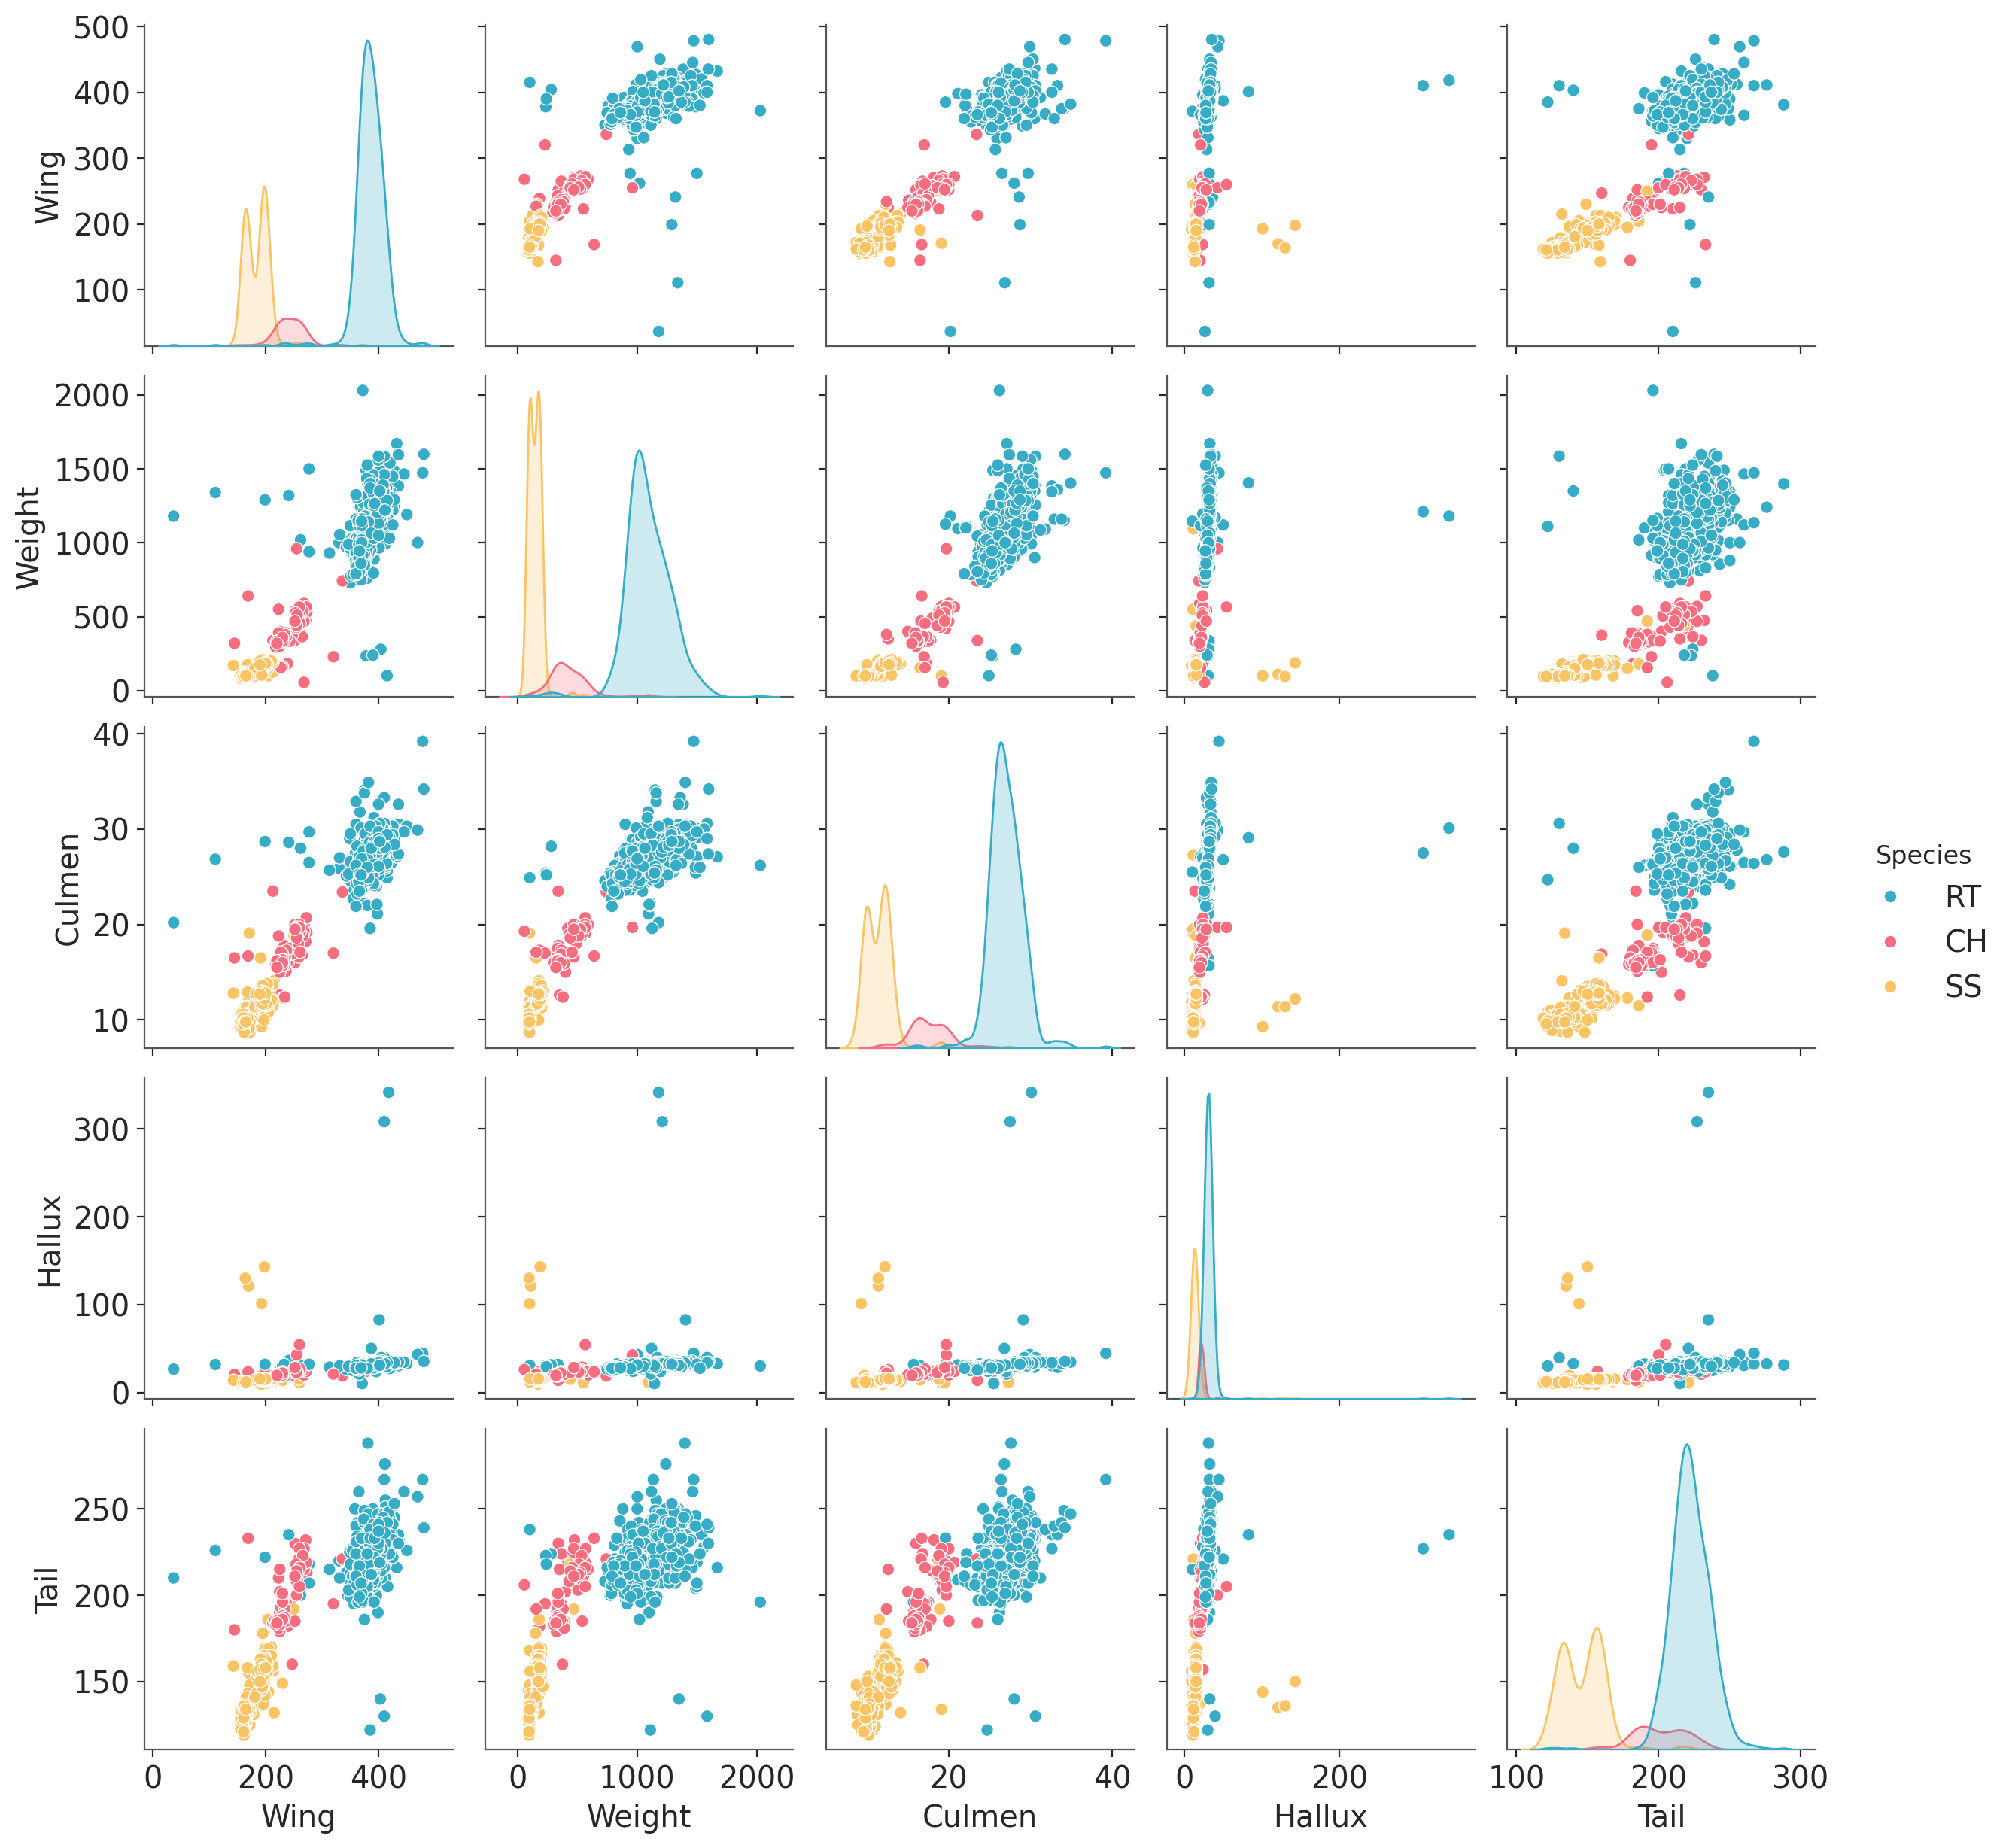

In [4]:
sns.pairplot(Hawks, hue="Species");

It can be seen that the RT species have distributions more differentiated than the other two in almost all covariables, and the covariables wing, weight, and culmen present certain separations between species. Still, none of the variables have a marked separation among the species distributions such that they can cleanly separate them. It is possible to make a combination of covariables, probably wing, weight, and culmen, to achieve the classification. These are the principal reasons for realizing the regression.  

## Model Specification  

First, we are going to prepare the data for the model, using "Species" as response and, "Wing", "Weight", "Culmen", "Hallux" and "Tail" as predictors. Using `pd.Categorical(Hawks['Species']).codes` we can codify the name species into integers between 0 and 2, being 0="CH", 1="RT" and 2="SS".  

In [5]:
y_0 = pd.Categorical(Hawks["Species"]).codes
x_0 = Hawks[["Wing", "Weight", "Culmen", "Hallux", "Tail"]]
print(len(x_0), x_0.shape, y_0.shape)

891 (891, 5) (891,)


We only can have an instance of {class}`~pymc_bart.BART()` in each pymc model (for now), so to model 3 species we can use coordinate and dimension names to specify the shapes of variables, *indicating* that there are 891 rows of information for 3 species. This step facilite the later selection of groups from the `InferenceData`.  

In [6]:
_, species = pd.factorize(Hawks["Species"], sort=True)
species

Index(['CH', 'RT', 'SS'], dtype='object')

In [7]:
coords = {"n_obs": np.arange(len(x_0)), "species": species}

In this model we use the `pm.math.softmax()` function, for $\mu$ from `pmb.BART()`, because guarantees that the vector sums to 1 along the `axis=0` in this case.  

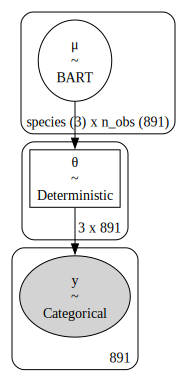

In [8]:
with pm.Model(coords=coords) as model_hawks:
    μ = pmb.BART("μ", x_0, y_0, m=50, dims=["species", "n_obs"])
    θ = pm.Deterministic("θ", pm.math.softmax(μ, axis=0))
    y = pm.Categorical("y", p=θ.T, observed=y_0)

pm.model_to_graphviz(model=model_hawks)

 Now fit the model and get samples from the posterior.

In [9]:
with model_hawks:
    idata = pm.sample(chains=4, compute_convergence_checks=False, random_seed=123)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 101 seconds.
Sampling: [y]


Output()

## Results  

### Variable Importance  

It may be that some of the input variables are not informative for classifying by species, so in the interest of parsimony and in reducing the computational cost of model estimation, it is useful to quantify the importance of each variable in the dataset. PyMC-BART provides the function {func}`~pymc_bart.compute_variable_importance()` and {func}`~pymc_bart.plot_variable_importance()`, that work together to generate a plot that shows on his x-axis the number of covariables and on the y-axis the R$^2$ between the predictions made for the full model (all variables included) and the restricted models, those with only a subset of the variables. The error bars represent the 94 % HDI from the posterior predictive distribution.

In [10]:
idata.posterior_predictive

<xarray.Dataset> Size: 29MB
Dimensions:  (chain: 4, draw: 1000, y_dim_0: 891)
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * y_dim_0  (y_dim_0) int64 7kB 0 1 2 3 4 5 6 7 ... 884 885 886 887 888 889 890
Data variables:
    y        (chain, draw, y_dim_0) int64 29MB 1 1 0 2 1 1 1 1 ... 1 1 1 0 1 1 1
Attributes:
    created_at:                 2025-12-02T12:21:24.250787+00:00
    arviz_version:              0.23.0.dev0
    inference_library:          pymc
    inference_library_version:  5.26.1

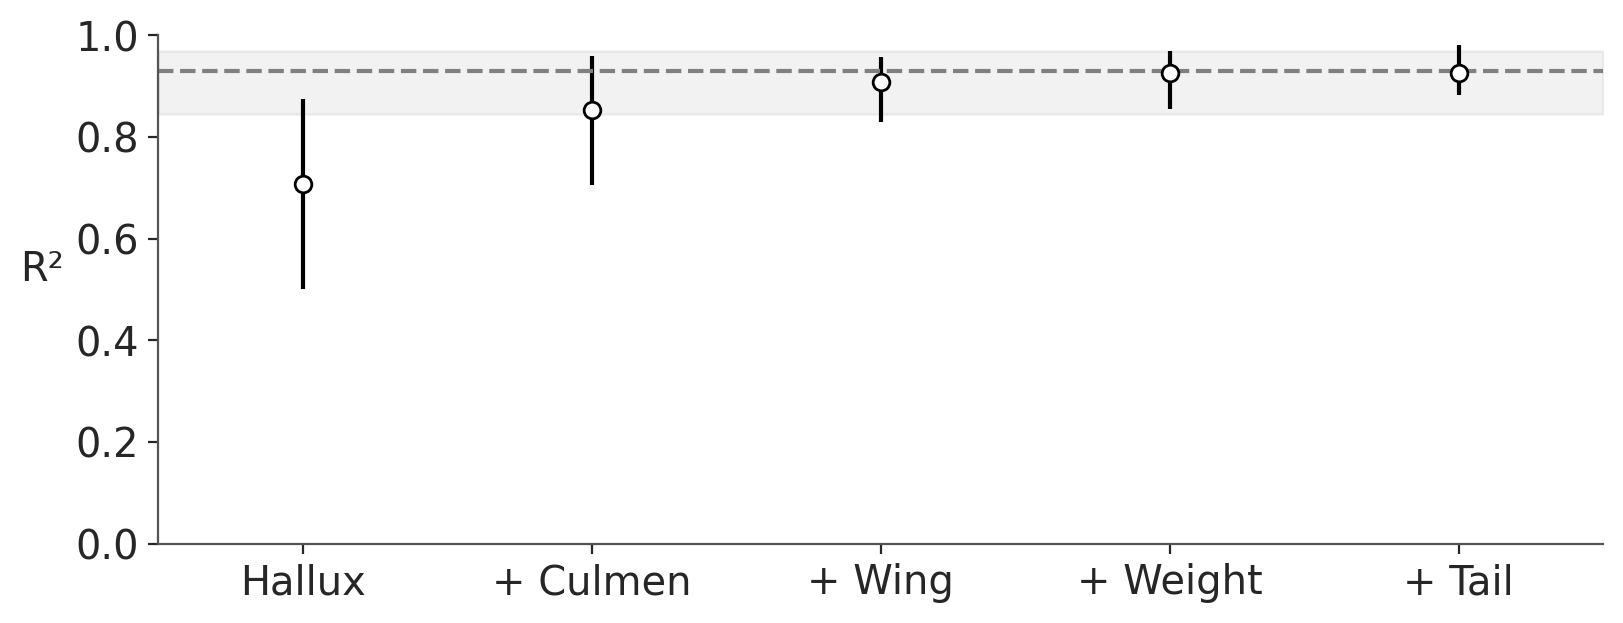

In [11]:
vi_results = pmb.compute_variable_importance(idata, μ, x_0, method="VI", random_seed=RANDOM_SEED)
pmb.plot_variable_importance(vi_results);

It can be observed that with the covariables `Hallux`, `Culmen`, and `Wing` we achieve the same $R^2$ value that we obtained with all the covariables, this is that the last two covariables contribute less than the other three to the classification. One thing we have to take into account in this is that the HDI is quite wide, which gives us less precision on the results; later we are going to see a way to reduce this.

We can also plot the scatter plot of the submodels' predictions to the full model's predictions to get an idea of how each new covariate improves the submodel's predictions.

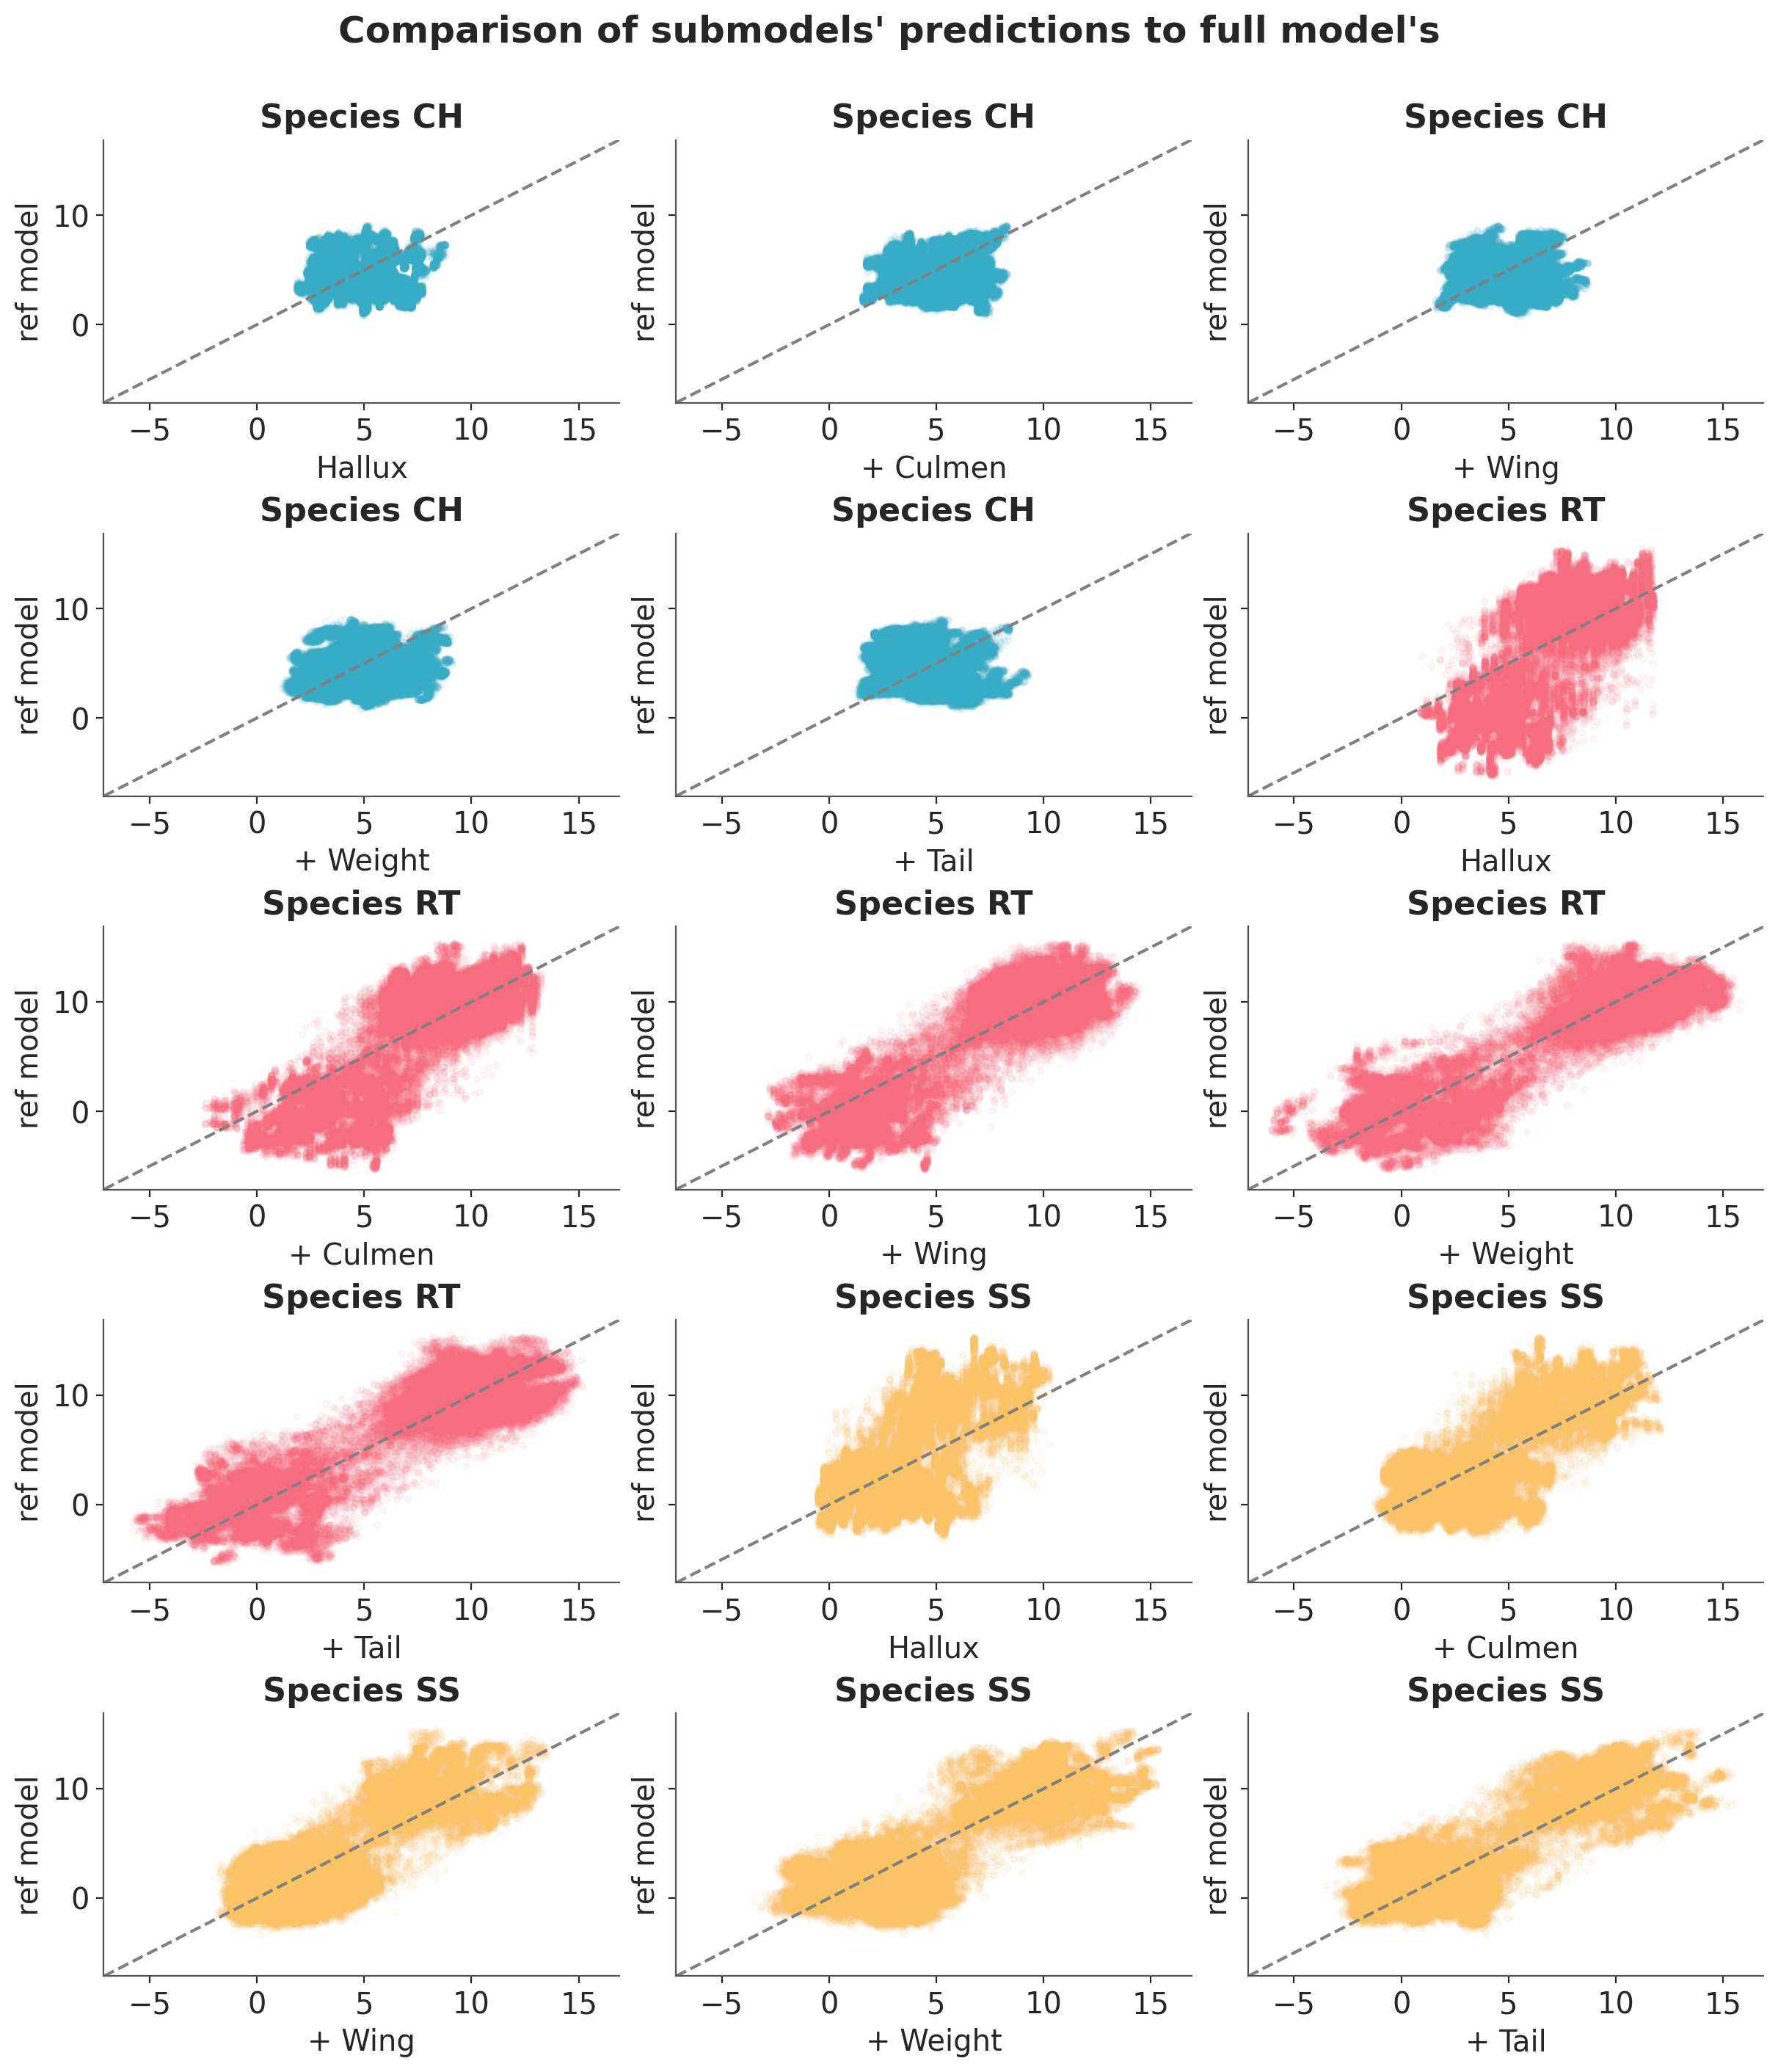

In [12]:
axes = pmb.plot_scatter_submodels(
    vi_results, grid=(5, 3), figsize=(12, 14), plot_kwargs={"alpha_scatter": 0.05}
)
plt.suptitle("Comparison of submodels' predictions to full model's\n", fontsize=18)
for ax, cat in zip(axes, np.repeat(species, len(vi_results["labels"]))):
    ax.set(title=f"Species {cat}")

### Partial Dependence Plot

Let's check the behavior of each covariable for each species with `pmb.plot_pdp()`, which shows the marginal effect a covariate has on the predicted variable, while we average over all the other covariates. Since our response variable is categorical, we'll pass `softmax` as the inverse link function to `plot_pdp`. 

You can see we have to be careful with the `softmax` function, because it's not vectorized: it considers relationships between elements, so the specific axis along which we apply it matters. By default, scipy applies to all axes, but we want to apply it to the last axis, since that's where the categories are. To make sure of that, we use `np.apply_along_axis` and pass it in a lambda function.

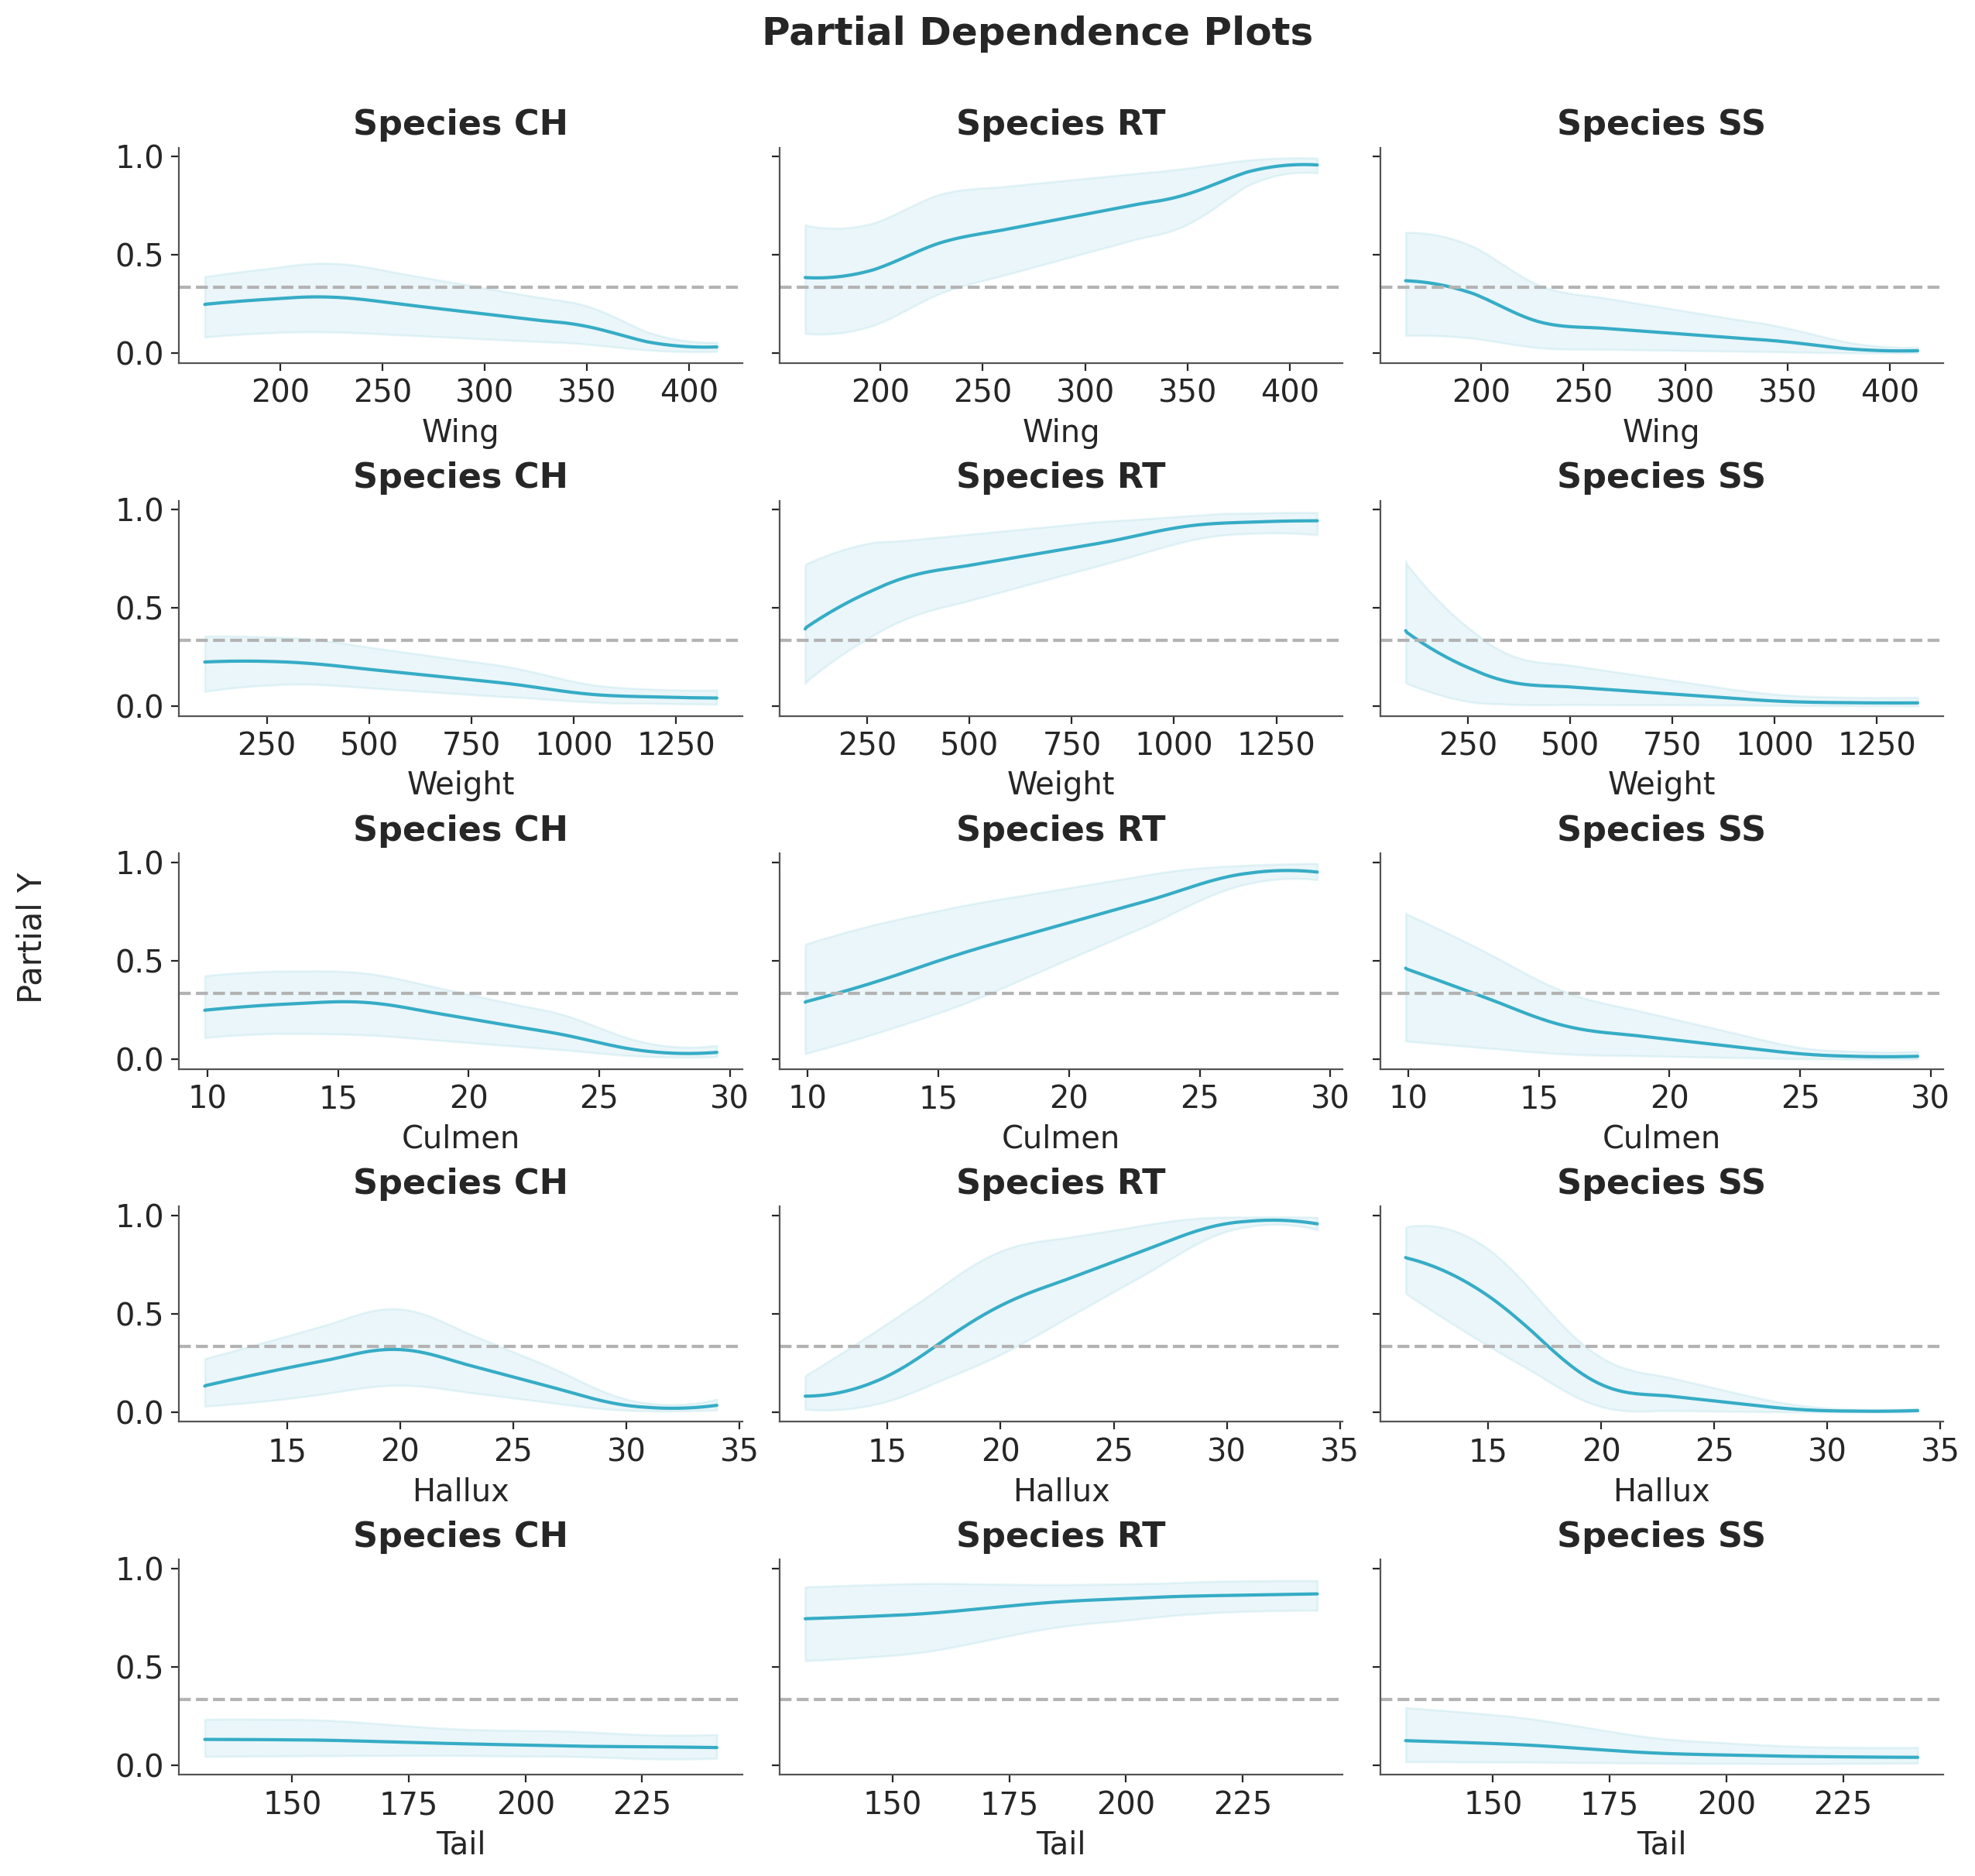

In [13]:
axes = pmb.plot_pdp(
    μ,
    X=x_0,
    Y=y_0,
    grid=(5, 3),
    figsize=(12, 12),
    func=lambda x: np.apply_along_axis(softmax, axis=-1, arr=x),
)
plt.suptitle("Partial Dependence Plots\n", fontsize=18)
for (i, ax), cat in zip(enumerate(axes), np.tile(species, len(vi_results["labels"]))):
    ax.set(title=f"Species {cat}")

The Partial Dependence Plot, together with the Variable Importance plot, confirms that `Tail` is the covariable with the smaller effect over the predicted variable: in the Variable Importance plot, `Tail` is the last covariate to be added and does not improve the result; in the PDP plot `Tail` has the flattest response. 

For the rest of the covariate in this plot, it's hard to see which of them have more effect over the predicted variable, because they have great variability, showed in the HDI width. 

Finally, some variability depends on the amount of data for each species, which we can see in the `counts` of each covariable for each species:

In [14]:
Hawks.groupby("Species").count()

Wing  Weight  Culmen  Hallux  Tail
Species                                    
CH         69      69      69      69    69
RT        567     567     567     567   567
SS        255     255     255     255   255

### Predicted vs Observed  

We are going to evaluate the model by comparing the predicted data against the observed data. This can be tricky to do with categorical data (and binary or ordinal data as well). For this reason we use PAV-adjusted calibration plots as described by {cite:t}`dimitriadis2021` and in a Bayesian context by {cite:t}`säilynoja2025`. 

In these plots the observed events are replaced with conditional event probabilities (CEP), which is the probability that a certain event occurs given that the classifier has assigned a specific predicted probability. 

We can esily generate this type of plots with the ArviZ's function `az.plot_ppc_pava()`, as this function also works for binary and ordinal data we need to specify `data_type="categorical"`.  You can read more about these plots [here](https://arviz-devs.github.io/EABM/Chapters/Prior_posterior_predictive_checks.html#posterior-predictive-checks-for-discrete-data).

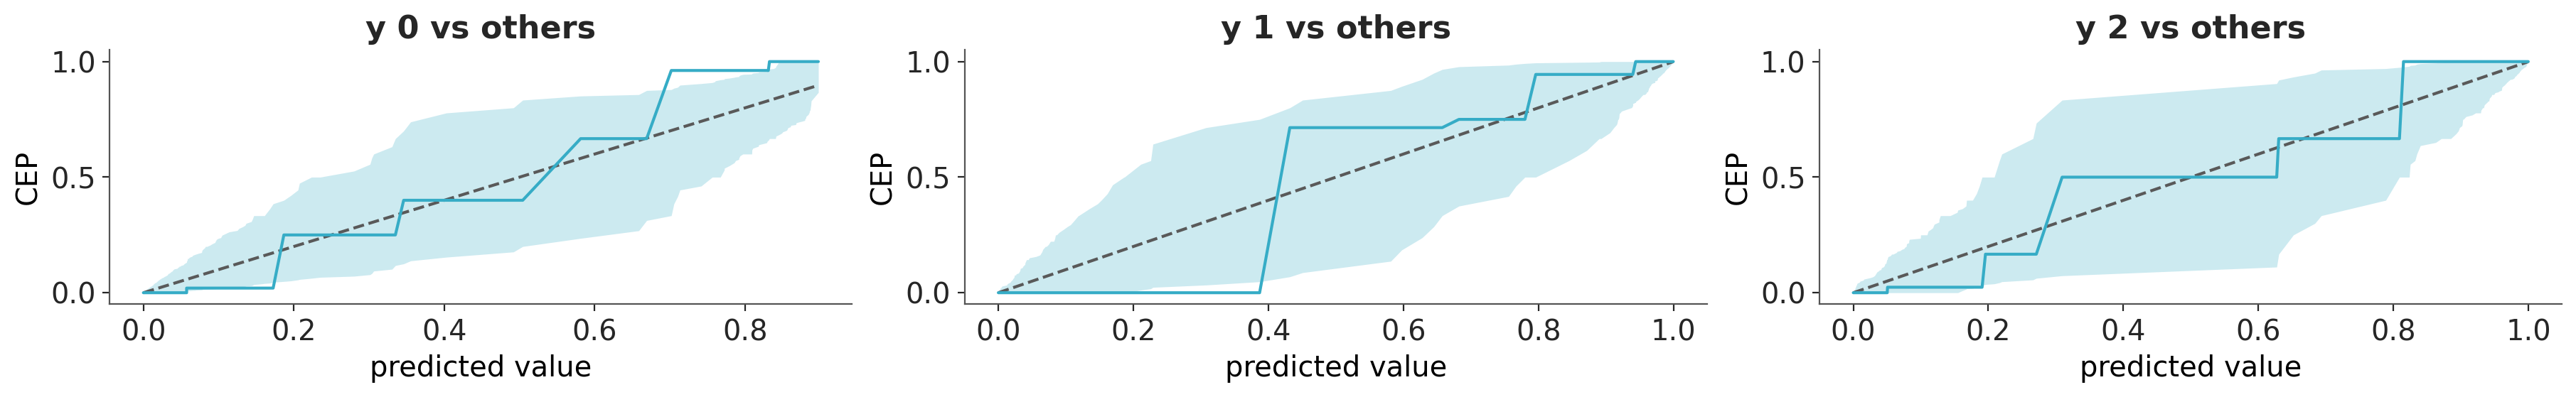

In [15]:
az.plot_ppc_pava(idata, data_type="categorical");

Each subplot is a category vs the others. The ideal calibration plot is a diagonal line, represented by the gray dashed line, where the predicted probabilities are equal to the observed frequencies. If the line is above the diagonal, the model is underestimating the probabilities, and if the line is below the diagonal, the model is overestimating the probabilities.

So far we have a very good result concerning the classification of the species based on the 5 covariables. However, if we want to select a subset of covariable to perform future classifications is not very clear which of them to select. Maybe something sure is that `Tail` could be eliminated. At the beginning when we plot the distribution of each covariable we said that the most important variables to make the classification could be `Wing`, `Weight` and, `Culmen`, nevertheless after running the model we saw that `Hallux`, `Culmen` and, `Wing`, proved to be the most important ones.

Unfortunately, the partial dependence plots show a very wide dispersion, making results look suspicious. One way to reduce this variability is adjusting independent trees, below we will see how to do this and get a more accurate result. 

## Fitting independent trees  

The option to fit independent trees with `pymc-bart` is set with the parameter `pmb.BART(..., separate_trees=True, ...)`. As we will see, for this example, using this option doesn't give a big difference in the predictions, but helps us to reduce the variability in the ppc and get a small improvement in the in-sample comparison. In case this option is used with bigger datasets you have to take into account that the model fits more slowly, so you can obtain a better result at the expense of computational cost. The following code runs the same model and analysis as before, but fitting independent trees. Compare the time to run this model with the previous one.  

In [16]:
with pm.Model(coords=coords) as model_t:
    μ_t = pmb.BART("μ", x_0, y_0, m=50, separate_trees=True, dims=["species", "n_obs"])
    θ_t = pm.Deterministic("θ", pm.math.softmax(μ_t, axis=0))
    y_t = pm.Categorical("y", p=θ_t.T, observed=y_0)
    idata_t = pm.sample(chains=4, compute_convergence_checks=False, random_seed=123)
    pm.sample_posterior_predictive(idata_t, extend_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [μ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 274 seconds.
Sampling: [y]


Output()

Now we are going to reproduce the same analyses as before.  

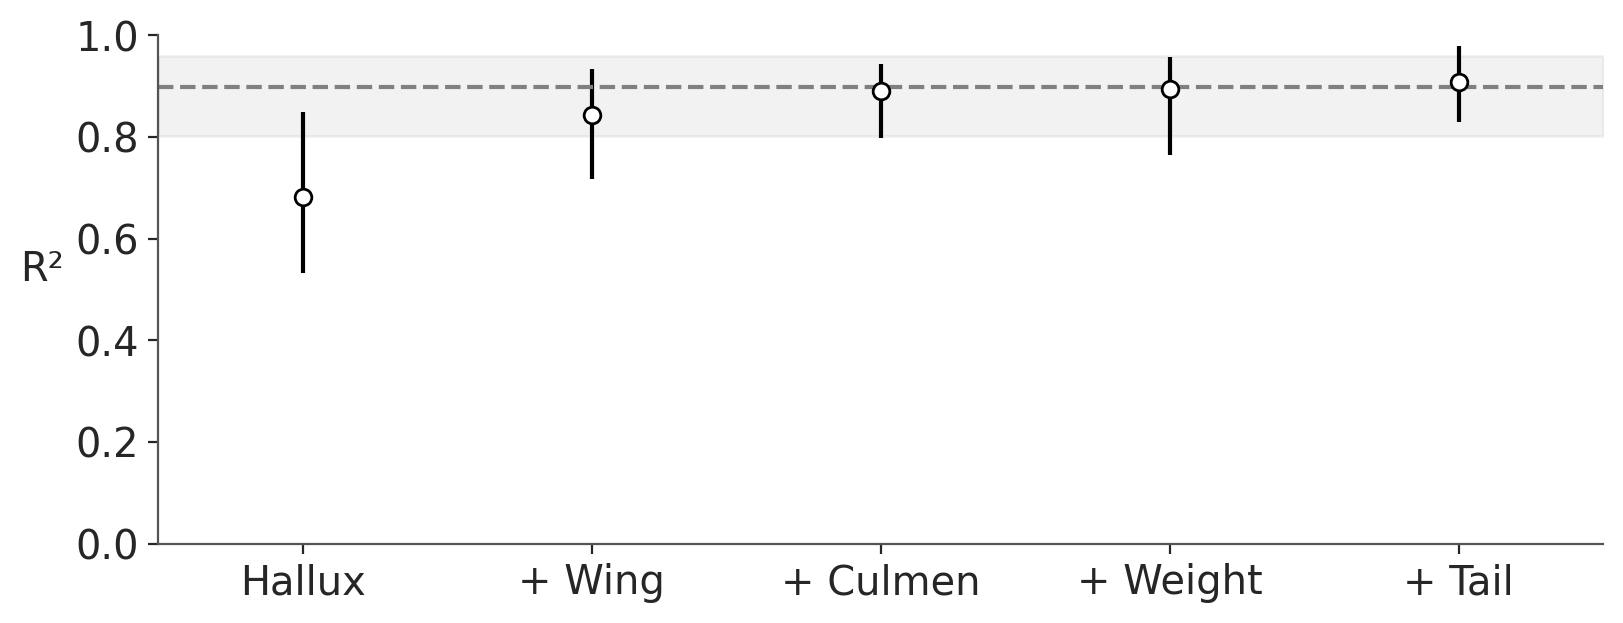

In [17]:
vi_results = pmb.compute_variable_importance(
    idata_t, μ_t, x_0, method="VI", random_seed=RANDOM_SEED
)
pmb.plot_variable_importance(vi_results);

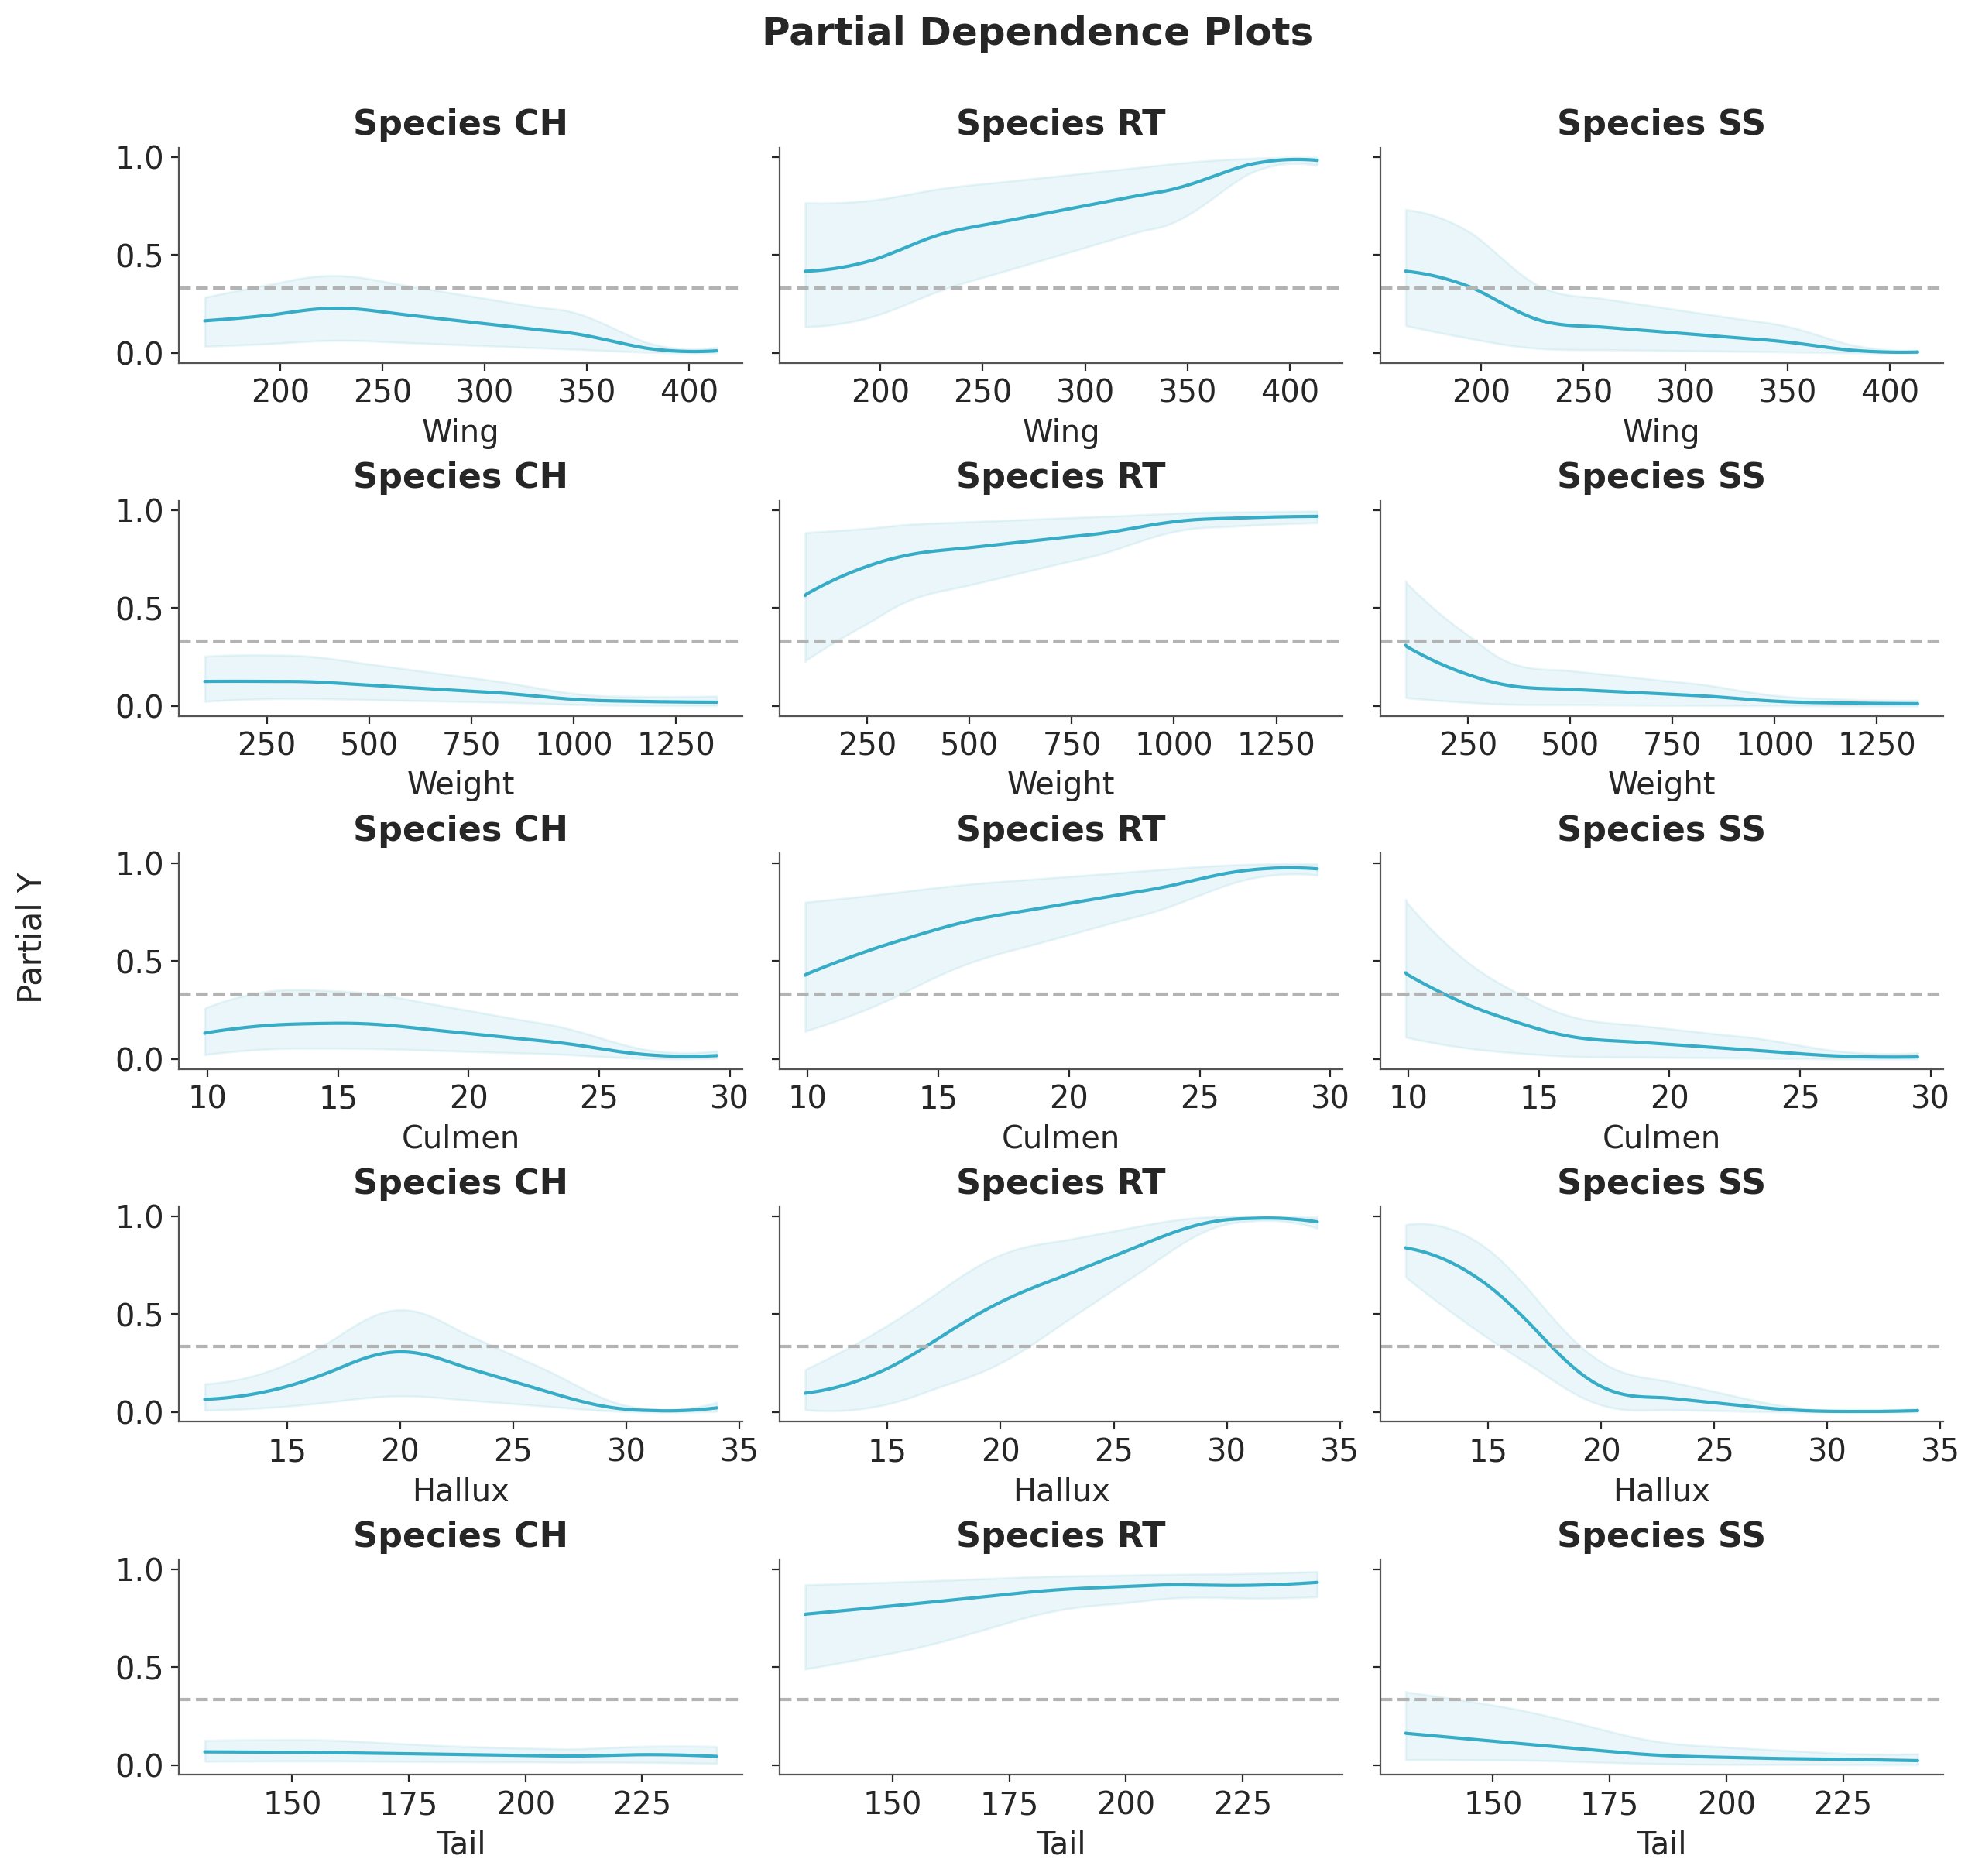

In [18]:
axes = pmb.plot_pdp(
    μ_t,
    X=x_0,
    Y=y_0,
    grid=(5, 3),
    figsize=(12, 12),
    func=lambda x: np.apply_along_axis(softmax, axis=-1, arr=x),
)
plt.suptitle("Partial Dependence Plots\n", fontsize=18)
for (i, ax), cat in zip(enumerate(axes), np.tile(species, len(vi_results["labels"]))):
    ax.set(title=f"Species {cat}")

Comparing these two plots with the previous ones shows a marked reduction in the variance for each one. In the case of `pmb.plot_variable_importance()` there are smallers error bands with an $R^{2}$ value closer to 1. And for `pmb.plot_pdp()` we can see thinner HDI bands. This is a representation of the reduction of the uncertainty due to adjusting the trees separately. Another benefit of this is that the behavior of each covariable for each one of the species is more visible.

With all these together, we can select `Hallux`, `Culmen`, and, `Wing` as covariables to make the classification.

Concerning the comparison between observed and predicted data, we can see that the model shows better calibration, as the lines are closer to the diagonal and the bands are in general less wide.

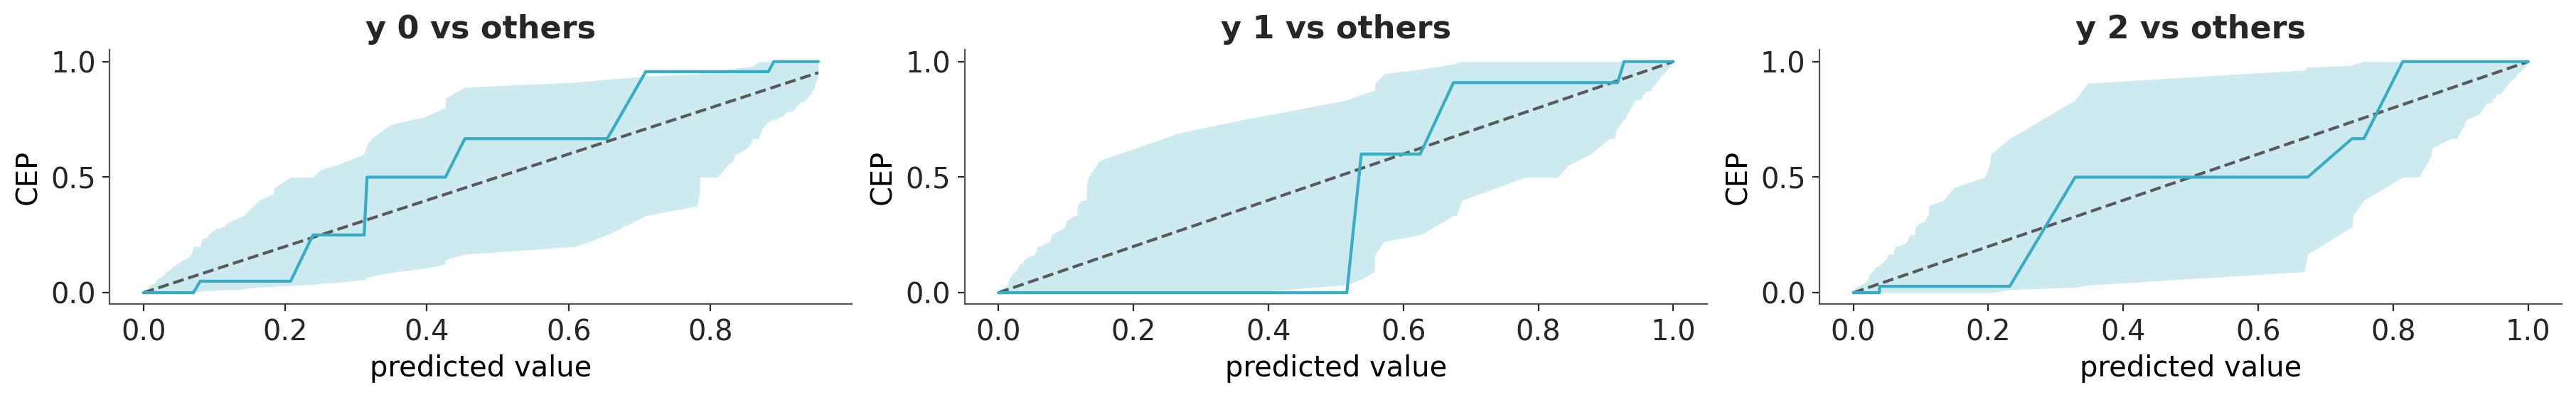

In [19]:
az.plot_ppc_pava(idata_t, data_type="categorical");

## Authors
- Authored by [Pablo Garay](https://github.com/PabloGGaray) and [Osvaldo Martin](https://aloctavodia.github.io/) in May, 2024
- Updated by Osvaldo Martin in Dec, 2024
- Expanded by [Alex Andorra](https://github.com/AlexAndorra) in Feb, 2025
- Updated by Osvaldo Martin in Dec, 2025

## References  
:::{bibliography} :filter: docname in docnames :::

## Watermark  

In [20]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Tue Dec 02 2025

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.3.0

pytensor: 2.35.1

pymc_bart : 0.11.0
seaborn   : 0.13.2
matplotlib: 3.10.3
scipy     : 1.15.3
pandas    : 2.3.0
pymc      : 5.26.1
arviz     : 0.23.0.dev0
numpy     : 2.2.6

Watermark: 2.5.0



:::{include} ../page_footer.md :::